In [2]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE

# Uploading excel files (previously generated by SAS)
data_gold14 = pd.read_excel('머신러닝데이터셋_GS14.xlsx') #data_gold=data for training and evaluation

In [3]:
data_label14 = data_gold14['Label']
data_feature14 = data_gold14.iloc[:,2:35]
from sklearn.model_selection import train_test_split

x_train14, x_test14, y_train14, y_test14 = train_test_split(data_feature14, data_label14, test_size = 0.25, random_state=200)

#모델설정
sm = SMOTE(random_state=0)

# train데이터를 넣어 복제함
X_resampled14, y_resampled14 = sm.fit_resample(x_train14, y_train14)

print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', x_train14.shape, y_train14.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', X_resampled14.shape, y_resampled14.shape)
print('SMOTE 적용 전 전체 레이블 값 분포: \n', pd.Series(data_label14).value_counts())
print('SMOTE 적용 전 학습 레이블 값 분포: \n', pd.Series(y_train14).value_counts())
print('SMOTE 적용 후 학습 레이블 값 분포: \n', pd.Series(y_resampled14).value_counts())

SMOTE 적용 전 학습용 피처/레이블 데이터 세트:  (171, 33) (171,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트:  (246, 33) (246,)
SMOTE 적용 전 전체 레이블 값 분포: 
 1    161
0     68
Name: Label, dtype: int64
SMOTE 적용 전 학습 레이블 값 분포: 
 1    123
0     48
Name: Label, dtype: int64
SMOTE 적용 후 학습 레이블 값 분포: 
 0    123
1    123
Name: Label, dtype: int64


In [4]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix, f1_score, precision_recall_curve, roc_curve  
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler

import xgboost as xgb
from xgboost import XGBClassifier, plot_importance

import warnings
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

In [5]:
xgb = XGBClassifier()

xgb_params_grid14 = {
         'n_estimators':[500], 'eta':[0.1],
         'max_depth':[2], 'min_child_weight':[3], 'gamma':[0.2], 
         'colsample_bytree':[0.8], 
         'random_state':[111]}

skf_infli = StratifiedKFold(n_splits=5)

xgb_14= GridSearchCV(xgb, param_grid=xgb_params_grid14, scoring="roc_auc", cv=skf_infli, n_jobs = -1, verbose = -1)
xgb_14.fit(X_resampled14, y_resampled14)

print("최고 평균 성능 : {0:.4f}".format(xgb_14.best_score_))
print("최고의 파라미터: ", xgb_14.best_params_)

[18:59:27] WARNING: D:\bld\xgboost-split_1634712635879\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
최고 평균 성능 : 0.8789
최고의 파라미터:  {'colsample_bytree': 0.8, 'eta': 0.1, 'gamma': 0.2, 'max_depth': 2, 'min_child_weight': 3, 'n_estimators': 500, 'random_state': 111}


C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


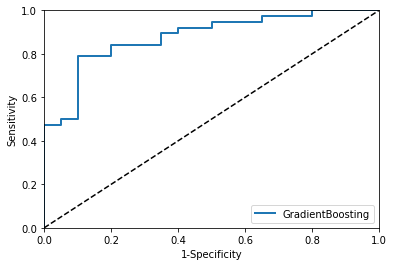

ROC AUC:0.8789


In [6]:
def plot_roc_curve(fpr,tpr,label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1],[0,1],'k--')
    plt.axis([0,1,0,1])
    plt.xlabel('1-Specificity')
    plt.ylabel('Sensitivity')
    
y_probs_gb14 = xgb_14.predict_proba(x_test14)
y_scores_gb14 = y_probs_gb14[:,1]
fpr_gb14, tpr_gb14, thresholds_gb14 = roc_curve(y_test14, y_scores_gb14)

plot_roc_curve(fpr_gb14, tpr_gb14, label='GradientBoosting')
plt.legend(loc="lower right")
plt.show()

xgb_roc_score14 = roc_auc_score(y_test14, xgb_14.predict_proba(x_test14)[:,1], average='macro')

print('ROC AUC:{0:.4f}'.format(xgb_roc_score14))    

<AxesSubplot:title={'center':'Feature importance'}, xlabel=' ', ylabel='Features'>

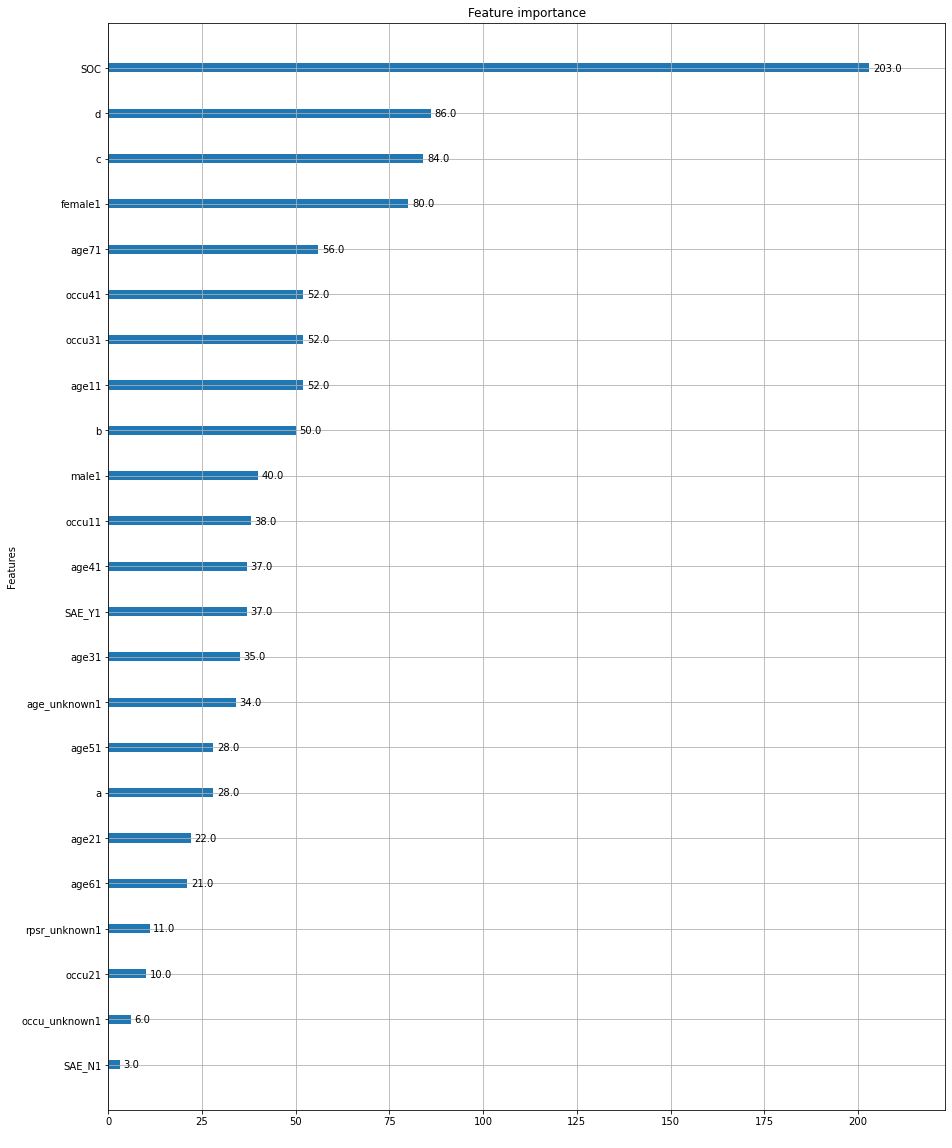

In [10]:
import xgboost

fig, ax = plt.subplots(figsize=(15,20))
xgboost.plot_importance(xgb_14.best_estimator_, xlabel = ' ', title = 'Feature importance', ax=ax)

In [33]:
data_unknown14 = pd.read_excel('머신러닝데이터셋_UK14.xlsx')
data_feature_UK14 = data_unknown14.iloc[:,1:35]

preds = xgb_14.predict_proba(data_feature_UK14)
threshold = 0.5
predicted = (preds[:,1] > threshold).astype('int')

predicted

array([1, 0, 1, 0])

In [62]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier()

parameters14 = {
    'n_estimators':[600],
    'max_depth':[14], 'min_samples_split':[5], 'min_samples_leaf':[2],
    'random_state':[111]}

rf_14 = GridSearchCV(rf_clf, param_grid=parameters14, scoring='roc_auc', cv=skf_infli, n_jobs = -1, verbose = -1)
rf_14.fit(X_resampled14,y_resampled14)

print("최고 평균 성능 : {0:.4f}".format(rf_14.best_score_))
print("최고의 파라미터: ", rf_14.best_params_)

rf_roc_score14 = roc_auc_score(y_test14, rf_14.predict_proba(x_test14)[:,1], average='macro')
print('ROC AUC:{0:.4f}'.format(rf_roc_score14)) 

최고 평균 성능 : 0.9097
최고의 파라미터:  {'max_depth': 14, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 600, 'random_state': 111}
ROC AUC:0.8553


## 인공지능

In [63]:
data_unknown14 = pd.read_excel('머신러닝데이터셋_UK14.xlsx')
data_feature_UK14 = data_unknown14.iloc[:,1:35]

preds = rf_14.predict_proba(data_feature_UK14)
threshold = 0.5
predicted_rf = (preds[:,1] > threshold).astype('int')

predicted_rf

array([0, 1, 1, 1])

## 2015년

In [35]:
data_gold15 = pd.read_excel('머신러닝데이터셋_GS15.xlsx')
data_label15 = data_gold15['Label']
data_feature15 = data_gold15.iloc[:,2:35]
x_train15, x_test15, y_train15, y_test15 = train_test_split(data_feature15, data_label15, test_size = 0.25, random_state=200)

X_resampled15, y_resampled15 = sm.fit_resample(x_train15, y_train15)

print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', x_train15.shape, y_train15.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', X_resampled15.shape, y_resampled15.shape)
print('SMOTE 적용 전 전체 레이블 값 분포: \n', pd.Series(data_label15).value_counts())
print('SMOTE 적용 전 학습 레이블 값 분포: \n', pd.Series(y_train15).value_counts())
print('SMOTE 적용 후 학습 레이블 값 분포: \n', pd.Series(y_resampled15).value_counts())

SMOTE 적용 전 학습용 피처/레이블 데이터 세트:  (207, 33) (207,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트:  (278, 33) (278,)
SMOTE 적용 전 전체 레이블 값 분포: 
 1    187
0     89
Name: Label, dtype: int64
SMOTE 적용 전 학습 레이블 값 분포: 
 1    139
0     68
Name: Label, dtype: int64
SMOTE 적용 후 학습 레이블 값 분포: 
 0    139
1    139
Name: Label, dtype: int64


In [36]:
xgb_params_grid15 = {
         'n_estimators':[500], 'eta':[0.01],
         'max_depth':[2], 'min_child_weight':[1], 'gamma':[0.6], 
         'colsample_bytree':[0.9],
         'random_state':[111]}

xgb_15= GridSearchCV(xgb, param_grid=xgb_params_grid15, scoring="roc_auc", cv=skf_infli, n_jobs = -1, verbose = -1)
xgb_15.fit(X_resampled15, y_resampled15)

print("최고 평균 성능 : {0:.4f}".format(xgb_15.best_score_))
print("최고의 파라미터: ", xgb_15.best_params_)

[17:35:03] WARNING: D:\bld\xgboost-split_1634712635879\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
최고 평균 성능 : 0.8032
최고의 파라미터:  {'colsample_bytree': 0.9, 'eta': 0.01, 'gamma': 0.6, 'max_depth': 2, 'min_child_weight': 1, 'n_estimators': 500, 'random_state': 111}


C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


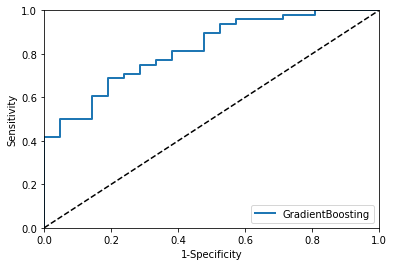

ROC AUC:0.8204


In [37]:
y_probs_gb15 = xgb_15.predict_proba(x_test15)
y_scores_gb15 = y_probs_gb15[:,1]
fpr_gb15, tpr_gb15, thresholds_gb15 = roc_curve(y_test15, y_scores_gb15)

plot_roc_curve(fpr_gb15, tpr_gb15, label='GradientBoosting')
plt.legend(loc="lower right")
plt.show()

xgb_roc_score15 = roc_auc_score(y_test15, xgb_15.predict_proba(x_test15)[:,1], average='macro')

print('ROC AUC:{0:.4f}'.format(xgb_roc_score15))  

<AxesSubplot:title={'center':'Feature importance'}, xlabel=' ', ylabel='Features'>

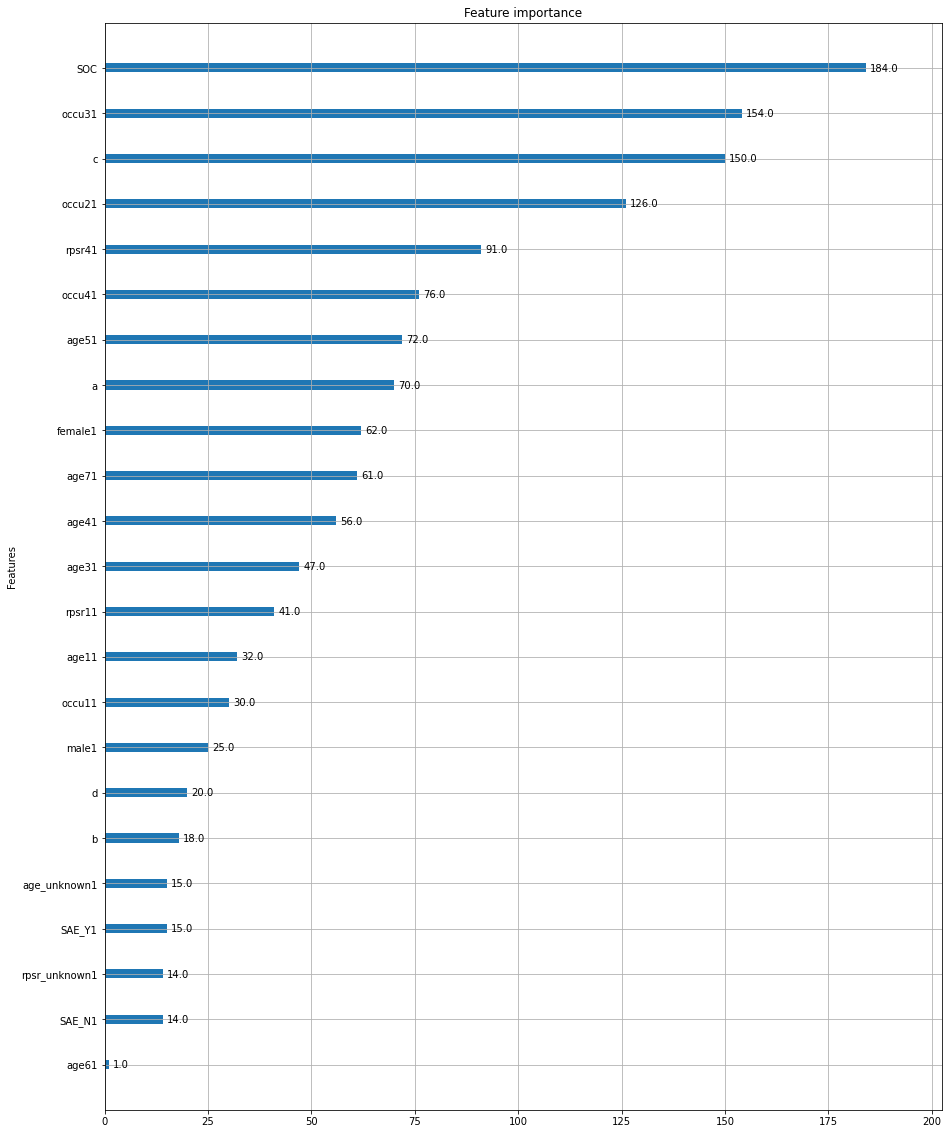

In [493]:
import xgboost

fig, ax = plt.subplots(figsize=(15,20))
xgboost.plot_importance(xgb_15.best_estimator_, xlabel = ' ', title = 'Feature importance', ax=ax)

In [38]:
data_unknown15 = pd.read_excel('머신러닝데이터셋_UK15.xlsx')
data_feature_UK15 = data_unknown15.iloc[:,1:35]

preds = xgb_15.predict_proba(data_feature_UK15)
threshold = 0.5
predicted = (preds[:,1] > threshold).astype('int')

predicted

array([0, 1, 1, 1])

In [100]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier()

parameters15 = {
    'n_estimators':[1200],
    'max_depth':[14], 'min_samples_split':[5], 'min_samples_leaf':[6],
    'random_state':[111]}

rf_15 = GridSearchCV(rf_clf, param_grid=parameters15, scoring='roc_auc', cv=skf_infli, n_jobs = -1, verbose = -1)
rf_15.fit(X_resampled15,y_resampled15)

print("최고 평균 성능 : {0:.4f}".format(rf_15.best_score_))
print("최고의 파라미터: ", rf_15.best_params_)

rf_roc_score15 = roc_auc_score(y_test15, rf_15.predict_proba(x_test15)[:,1], average='macro')
print('ROC AUC:{0:.4f}'.format(rf_roc_score15)) 

최고 평균 성능 : 0.8182
최고의 파라미터:  {'max_depth': 14, 'min_samples_leaf': 6, 'min_samples_split': 5, 'n_estimators': 1200, 'random_state': 111}
ROC AUC:0.7887


In [101]:
data_unknown15 = pd.read_excel('머신러닝데이터셋_UK15.xlsx')
data_feature_UK15 = data_unknown15.iloc[:,1:35]

preds = rf_15.predict_proba(data_feature_UK15)
threshold = 0.5
predicted_rf = (preds[:,1] > threshold).astype('int')

predicted_rf

array([0, 1, 1, 1])

## 2016년

In [148]:
data_gold16 = pd.read_excel('머신러닝데이터셋_GS16.xlsx')
data_label16 = data_gold16['Label']
data_feature16 = data_gold16.iloc[:,2:35]
x_train16, x_test16, y_train16, y_test16 = train_test_split(data_feature16, data_label16, test_size = 0.25, random_state=200)

X_resampled16, y_resampled16 = sm.fit_resample(x_train16, y_train16)

print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', x_train16.shape, y_train16.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', X_resampled16.shape, y_resampled16.shape)
print('SMOTE 적용 전 전체 레이블 값 분포: \n', pd.Series(data_label16).value_counts())
print('SMOTE 적용 전 학습 레이블 값 분포: \n', pd.Series(y_train16).value_counts())
print('SMOTE 적용 후 학습 레이블 값 분포: \n', pd.Series(y_resampled16).value_counts())

SMOTE 적용 전 학습용 피처/레이블 데이터 세트:  (219, 33) (219,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트:  (284, 33) (284,)
SMOTE 적용 전 전체 레이블 값 분포: 
 1    191
0    102
Name: Label, dtype: int64
SMOTE 적용 전 학습 레이블 값 분포: 
 1    142
0     77
Name: Label, dtype: int64
SMOTE 적용 후 학습 레이블 값 분포: 
 0    142
1    142
Name: Label, dtype: int64


In [40]:
xgb_params_grid16 = {
         'n_estimators':[500], 'eta':[0.01], 
         'max_depth':[4], 'min_child_weight':[10],'gamma':[1], 
         'colsample_bytree':[1], 
         'random_state':[111]}

xgb_16= GridSearchCV(xgb, param_grid=xgb_params_grid16, scoring="roc_auc", cv=skf_infli, n_jobs = -1, verbose = -1)
xgb_16.fit(X_resampled16, y_resampled16)

print("최고 평균 성능 : {0:.4f}".format(xgb_16.best_score_))
print("최고의 파라미터: ", xgb_16.best_params_)


[17:35:18] WARNING: D:\bld\xgboost-split_1634712635879\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
최고 평균 성능 : 0.8100
최고의 파라미터:  {'colsample_bytree': 1, 'eta': 0.01, 'gamma': 1, 'max_depth': 4, 'min_child_weight': 10, 'n_estimators': 500, 'random_state': 111}


C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


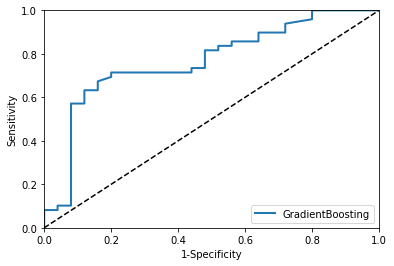

ROC AUC:0.7661


In [41]:
y_probs_gb16 = xgb_16.predict_proba(x_test16)
y_scores_gb16 = y_probs_gb16[:,1]
fpr_gb16, tpr_gb16, thresholds_gb16 = roc_curve(y_test16, y_scores_gb16)

plot_roc_curve(fpr_gb16, tpr_gb16, label='GradientBoosting')
plt.legend(loc="lower right")
plt.show()

xgb_roc_score16 = roc_auc_score(y_test16, xgb_16.predict_proba(x_test16)[:,1], average='macro')

print('ROC AUC:{0:.4f}'.format(xgb_roc_score16)) 

<AxesSubplot:title={'center':'Feature importance'}, xlabel=' ', ylabel='Features'>

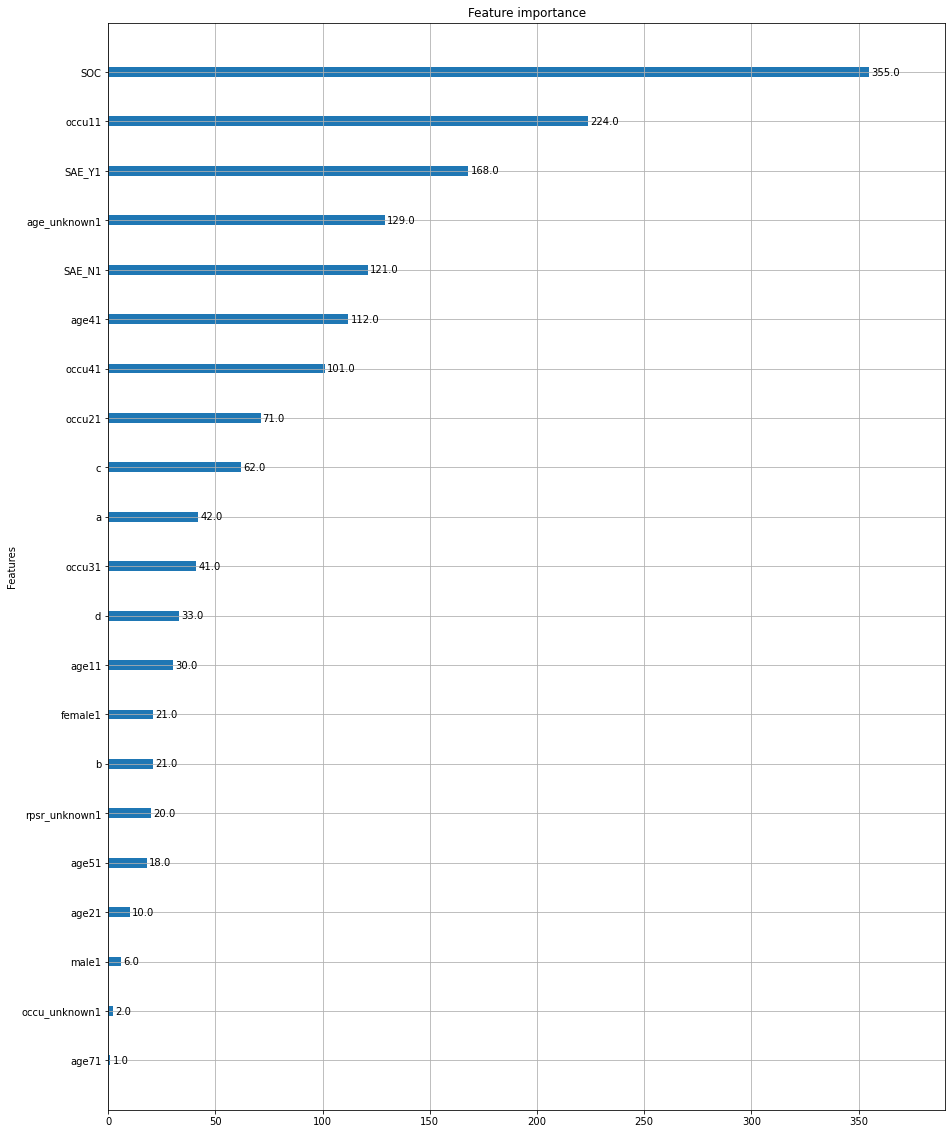

In [577]:
import xgboost

fig, ax = plt.subplots(figsize=(15,20))
xgboost.plot_importance(xgb_16.best_estimator_, xlabel = ' ', title = 'Feature importance', ax=ax)

In [42]:
data_unknown16 = pd.read_excel('머신러닝데이터셋_UK16.xlsx')
data_feature_UK16 = data_unknown16.iloc[:,1:35]

preds = xgb_16.predict_proba(data_feature_UK16)
threshold = 0.5
predicted = (preds[:,1] >= threshold).astype('int')

predicted

array([0, 0, 1, 1])

In [149]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier()

parameters16 = {
    'n_estimators':[1200],
    'max_depth':[8], 'min_samples_split':[4],'min_samples_leaf':[6],
    'random_state':[111]}

rf_16 = GridSearchCV(rf_clf, param_grid=parameters16, scoring='roc_auc', cv=skf_infli, n_jobs = -1, verbose = -1)
rf_16.fit(X_resampled16,y_resampled16)

print("최고 평균 성능 : {0:.4f}".format(rf_16.best_score_))
print("최고의 파라미터: ", rf_16.best_params_)

rf_roc_score16 = roc_auc_score(y_test16, rf_16.predict_proba(x_test16)[:,1], average='macro')
print('ROC AUC:{0:.4f}'.format(rf_roc_score16)) 

최고 평균 성능 : 0.8399
최고의 파라미터:  {'max_depth': 8, 'min_samples_leaf': 6, 'min_samples_split': 4, 'n_estimators': 1200, 'random_state': 111}
ROC AUC:0.7445


In [140]:
data_unknown16 = pd.read_excel('머신러닝데이터셋_UK16.xlsx')
data_feature_UK16 = data_unknown16.iloc[:,1:35]

preds = rf_16.predict_proba(data_feature_UK16)
threshold = 0.5
predicted_rf = (preds[:,1] > threshold).astype('int')

predicted_rf

array([0, 1, 1, 1])

## 2017년

In [186]:
data_gold17 = pd.read_excel('머신러닝데이터셋_GS17.xlsx')
data_label17 = data_gold17['Label']
data_feature17 = data_gold17.iloc[:,2:35]

x_train17, x_test17, y_train17, y_test17 = train_test_split(data_feature17, data_label17, test_size = 0.25, random_state=200)
X_resampled17, y_resampled17 = sm.fit_resample(x_train17, y_train17)

print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', x_train17.shape, y_train17.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', X_resampled17.shape, y_resampled17.shape)
print('SMOTE 적용 전 전체 레이블 값 분포: \n', pd.Series(data_label17).value_counts())
print('SMOTE 적용 전 학습 레이블 값 분포: \n', pd.Series(y_train17).value_counts())
print('SMOTE 적용 후 학습 레이블 값 분포: \n', pd.Series(y_resampled17).value_counts())

SMOTE 적용 전 학습용 피처/레이블 데이터 세트:  (226, 33) (226,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트:  (292, 33) (292,)
SMOTE 적용 전 전체 레이블 값 분포: 
 1    195
0    107
Name: Label, dtype: int64
SMOTE 적용 전 학습 레이블 값 분포: 
 1    146
0     80
Name: Label, dtype: int64
SMOTE 적용 후 학습 레이블 값 분포: 
 0    146
1    146
Name: Label, dtype: int64


In [187]:
xgb_params_grid17 = {
         'n_estimators':[500], 'eta':[0.05],
         'max_depth':[2], 'min_child_weight':[2],'gamma':[0.5], 
         'colsample_bytree':[0.6], 
         'random_state':[111]}

xgb_17= GridSearchCV(xgb, param_grid=xgb_params_grid17, scoring="roc_auc", cv=skf_infli, n_jobs = -1, verbose = -1)
xgb_17.fit(X_resampled17, y_resampled17)

print("최고 평균 성능 : {0:.4f}".format(xgb_17.best_score_))
print("최고의 파라미터: ", xgb_17.best_params_)

y_probs_gb17 = xgb_17.predict_proba(x_test17)
y_scores_gb17 = y_probs_gb17[:,1]
fpr_gb17, tpr_gb17, thresholds_gb17 = roc_curve(y_test17, y_scores_gb17)
xgb_roc_score17 = roc_auc_score(y_test17, xgb_17.predict_proba(x_test17)[:,1], average='macro')
print('ROC AUC:{0:.4f}'.format(xgb_roc_score17)) 

[18:17:00] WARNING: D:\bld\xgboost-split_1634712635879\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
최고 평균 성능 : 0.8352
최고의 파라미터:  {'colsample_bytree': 0.6, 'eta': 0.05, 'gamma': 0.5, 'max_depth': 2, 'min_child_weight': 2, 'n_estimators': 500, 'random_state': 111}
ROC AUC:0.7649


C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


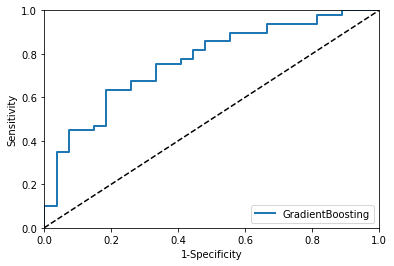

ROC AUC:0.7649


In [188]:
y_probs_gb17 = xgb_17.predict_proba(x_test17)
y_scores_gb17 = y_probs_gb17[:,1]
fpr_gb17, tpr_gb17, thresholds_gb17 = roc_curve(y_test17, y_scores_gb17)

plot_roc_curve(fpr_gb17, tpr_gb17, label='GradientBoosting')
plt.legend(loc="lower right")
plt.show()

xgb_roc_score17 = roc_auc_score(y_test17, xgb_17.predict_proba(x_test17)[:,1], average='macro')

print('ROC AUC:{0:.4f}'.format(xgb_roc_score17)) 

In [189]:
data_unknown17 = pd.read_excel('머신러닝데이터셋_UK17.xlsx')
data_feature_UK17 = data_unknown17.iloc[:,1:35]

preds = xgb_17.predict_proba(data_feature_UK17)
threshold = 0.5
predicted = (preds[:,1] >= threshold).astype('int')

predicted

array([0, 1, 1, 1])

In [182]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier()

parameters17 = {
    'n_estimators':[1200],
    'max_depth':[10], 'min_samples_split':[6], 'min_samples_leaf':[1],
    'random_state':[111]}

rf_17 = GridSearchCV(rf_clf, param_grid=parameters17, scoring='roc_auc', cv=skf_infli, n_jobs = -1, verbose = -1)
rf_17.fit(X_resampled17,y_resampled17)

print("최고 평균 성능 : {0:.4f}".format(rf_17.best_score_))
print("최고의 파라미터: ", rf_17.best_params_)

rf_roc_score17 = roc_auc_score(y_test17, rf_17.predict_proba(x_test17)[:,1], average='macro')
print('ROC AUC:{0:.4f}'.format(rf_roc_score17)) 

최고 평균 성능 : 0.8545
최고의 파라미터:  {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 1200, 'random_state': 111}
ROC AUC:0.7649


In [183]:
data_unknown17 = pd.read_excel('머신러닝데이터셋_UK17.xlsx')
data_feature_UK17 = data_unknown17.iloc[:,1:35]

preds = rf_17.predict_proba(data_feature_UK17)
threshold = 0.5
predicted_rf = (preds[:,1] > threshold).astype('int')

predicted_rf

array([0, 1, 1, 1])

## 2018년

In [191]:
data_gold18 = pd.read_excel('머신러닝데이터셋_GS18.xlsx')
data_label18 = data_gold18['Label']
data_feature18 = data_gold18.iloc[:,2:35]

x_train18, x_test18, y_train18, y_test18 = train_test_split(data_feature18, data_label18, test_size = 0.25, random_state=200)
X_resampled18, y_resampled18 = sm.fit_resample(x_train18, y_train18)

print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', x_train18.shape, y_train18.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', X_resampled18.shape, y_resampled18.shape)
print('SMOTE 적용 전 전체 레이블 값 분포: \n', pd.Series(data_label18).value_counts())
print('SMOTE 적용 전 학습 레이블 값 분포: \n', pd.Series(y_train18).value_counts())
print('SMOTE 적용 후 학습 레이블 값 분포: \n', pd.Series(y_resampled18).value_counts())

SMOTE 적용 전 학습용 피처/레이블 데이터 세트:  (227, 33) (227,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트:  (296, 33) (296,)
SMOTE 적용 전 전체 레이블 값 분포: 
 1    195
0    108
Name: Label, dtype: int64
SMOTE 적용 전 학습 레이블 값 분포: 
 1    148
0     79
Name: Label, dtype: int64
SMOTE 적용 후 학습 레이블 값 분포: 
 0    148
1    148
Name: Label, dtype: int64


In [190]:
xgb_params_grid18 = {
         'n_estimators':[100], 'eta':[0.01],
         'max_depth':[3], 'min_child_weight':[1], 'gamma':[0.1], 
         'colsample_bytree':[0.7], 
         'random_state':[111]}

xgb_18= GridSearchCV(xgb, param_grid=xgb_params_grid18, scoring="roc_auc", cv=skf_infli, n_jobs = -1, verbose = -1)
xgb_18.fit(X_resampled18, y_resampled18)

print("최고 평균 성능 : {0:.4f}".format(xgb_18.best_score_))
print("최고의 파라미터: ", xgb_18.best_params_)

[18:17:13] WARNING: D:\bld\xgboost-split_1634712635879\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
최고 평균 성능 : 0.8044
최고의 파라미터:  {'colsample_bytree': 0.7, 'eta': 0.01, 'gamma': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'random_state': 111}


C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


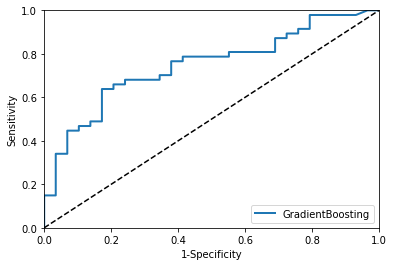

ROC AUC:0.7472


In [20]:
y_probs_gb18 = xgb_18.predict_proba(x_test18)
y_scores_gb18 = y_probs_gb18[:,1]
fpr_gb18, tpr_gb18, thresholds_gb18 = roc_curve(y_test18, y_scores_gb18)

plot_roc_curve(fpr_gb18, tpr_gb18, label='GradientBoosting')
plt.legend(loc="lower right")
plt.show()

xgb_roc_score18 = roc_auc_score(y_test18, xgb_18.predict_proba(x_test18)[:,1], average='macro')

print('ROC AUC:{0:.4f}'.format(xgb_roc_score18)) 

In [192]:
data_unknown18 = pd.read_excel('머신러닝데이터셋_UK18.xlsx')
data_feature_UK18 = data_unknown18.iloc[:,1:35]

preds = xgb_18.predict_proba(data_feature_UK18)
threshold = 0.5
predicted = (preds[:,1] > threshold).astype('int')

predicted

array([0, 1, 1, 1])

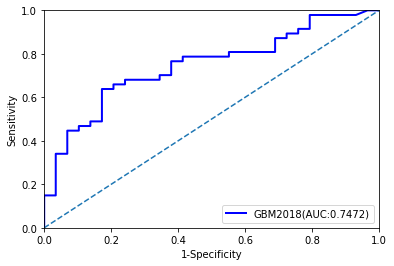

In [22]:
def plot_roc_curve18(fpr,tpr,label=None):
    plt.plot(fpr, tpr, linewidth=2, color='blue', label=label)
    plt.plot([0,1],[0,1], linestyle= '--')
    plt.axis([0,1,0,1])
    plt.xlabel('1-Specificity')
    plt.ylabel('Sensitivity')

plot_roc_curve18(fpr_gb18, tpr_gb18,label='GBM2018(AUC:0.7472)')
plt.legend(loc="lower right")
plt.show()

In [24]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier()

parameters18 = {
    'n_estimators':[700],
    'max_depth':[1], 
    'min_samples_split':[2], 
    'min_samples_leaf':[8], 'random_state':[111]}

rf_18 = GridSearchCV(rf_clf, param_grid=parameters18, scoring='roc_auc', cv=skf_infli, n_jobs = -1, verbose = -1)
rf_18.fit(X_resampled18,y_resampled18)

print("최고 평균 성능 : {0:.4f}".format(rf_18.best_score_))
print("최고의 파라미터: ", rf_18.best_params_)

y_probs_rf18 = rf_18.predict_proba(x_test18)
y_scores_rf18 = y_probs_rf18[:,1]
fpr_rf18, tpr_rf18, thresholds_rf18 = roc_curve(y_test18, y_scores_rf18)

rf_roc_score18 = roc_auc_score(y_test18, rf_18.predict_proba(x_test18)[:,1], average='macro')
print('ROC AUC:{0:.4f}'.format(rf_roc_score18)) 

최고 평균 성능 : 0.7565
최고의 파라미터:  {'max_depth': 1, 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 700, 'random_state': 111}
ROC AUC:0.7274


In [184]:
data_unknown18 = pd.read_excel('머신러닝데이터셋_UK18.xlsx')
data_feature_UK18 = data_unknown18.iloc[:,1:35]

preds = rf_18.predict_proba(data_feature_UK18)
threshold = 0.5
predicted_rf = (preds[:,1] > threshold).astype('int')

predicted_rf

array([0, 1, 1, 1])

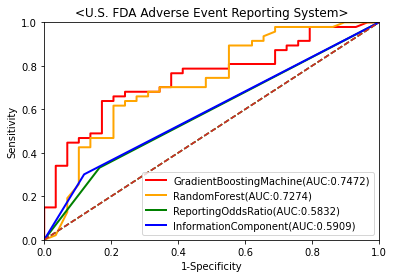

In [27]:
def plot_roc_curve_gbm18(fpr,tpr,label=None):
    plt.plot(fpr, tpr, linewidth=2, color='red', label=label)
    plt.plot([0,1],[0,1], linestyle= '--')
    plt.axis([0,1,0,1])
    plt.xlabel('1-Specificity')
    plt.ylabel('Sensitivity')
    plt.title('<U.S. FDA Adverse Event Reporting System>')

def plot_roc_curve_rf18(fpr,tpr,label=None):
    plt.plot(fpr, tpr, linewidth=2, color='orange', label=label)
    plt.plot([0,1],[0,1], linestyle= '--')
    plt.axis([0,1,0,1])
    plt.xlabel('1-Specificity')
    plt.ylabel('Sensitivity')
    
def plot_roc_curve_ror(fpr,tpr,label=None):
    plt.plot(fpr, tpr, linewidth=2, color='green', label=label)
    plt.plot([0,1],[0,1], linestyle= '--')
    plt.axis([0,1,0,1])
    plt.xlabel('1-Specificity')
    plt.ylabel('Sensitivity')
    
def plot_roc_curve_ic(fpr,tpr,label=None):
    plt.plot(fpr, tpr, linewidth=2, color='blue', label=label)
    plt.plot([0,1],[0,1], linestyle= '--')
    plt.axis([0,1,0,1])
    plt.xlabel('1-Specificity')
    plt.ylabel('Sensitivity')

tpr_ror = [0, 0.331633, 1]
fpr_ror = [0, 0.165138, 1]

tpr_ic = [0, 0.30102,  1]
fpr_ic = [0, 0.119266, 1]


plot_roc_curve_gbm18(fpr_gb18, tpr_gb18,label='GradientBoostingMachine(AUC:0.7472)')
plot_roc_curve_rf18(fpr_rf18, tpr_rf18,label='RandomForest(AUC:0.7274)')
plot_roc_curve_ror(fpr_ror, tpr_ror, label='ReportingOddsRatio(AUC:0.5832)')
plot_roc_curve_ic(fpr_ic, tpr_ic, label='InformationComponent(AUC:0.5909)')
plt.legend(loc="lower right")
plt.savefig('FAERS', dpi=300)
plt.show()

## KAERS 재분석

In [7]:
data_gold18_KAERS = pd.read_excel('머신러닝데이터셋_GS2018.xlsx')

In [8]:
data_label_KAERS = data_gold18_KAERS['Label']
data_feature_KAERS = data_gold18_KAERS.iloc[:,2:33]

x_train_KAERS, x_test_KAERS, y_train_KAERS, y_test_KAERS = train_test_split(data_feature_KAERS, data_label_KAERS, test_size = 0.25, random_state=200)
X_resampled_KAERS, y_resampled_KAERS = sm.fit_resample(x_train_KAERS, y_train_KAERS)

print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', x_train_KAERS.shape, y_train_KAERS.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', X_resampled_KAERS.shape, y_resampled_KAERS.shape)
print('SMOTE 적용 전 전체 레이블 값 분포: \n', pd.Series(data_label_KAERS).value_counts())
print('SMOTE 적용 전 학습 레이블 값 분포: \n', pd.Series(y_train_KAERS).value_counts())
print('SMOTE 적용 후 학습 레이블 값 분포: \n', pd.Series(y_resampled_KAERS).value_counts())

SMOTE 적용 전 학습용 피처/레이블 데이터 세트:  (243, 31) (243,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트:  (298, 31) (298,)
SMOTE 적용 전 전체 레이블 값 분포: 
 1    197
0    127
Name: Label, dtype: int64
SMOTE 적용 전 학습 레이블 값 분포: 
 1    149
0     94
Name: Label, dtype: int64
SMOTE 적용 후 학습 레이블 값 분포: 
 0    149
1    149
Name: Label, dtype: int64


In [9]:
xgb_params_grid_KAERS = {
         'n_estimators':[300], 'eta':[0.1],  
         'max_depth':[8], 'min_child_weight':[5],
         'gamma':[0.5], 'colsample_bytree':[0.5],
         'random_state':[111]}

xgb_KAERS=GridSearchCV(xgb, param_grid=xgb_params_grid_KAERS, scoring="roc_auc", cv=skf_infli, n_jobs = -1, verbose = -1)
xgb_KAERS.fit(X_resampled_KAERS, y_resampled_KAERS)

print("최고 평균 성능 : {0:.4f}".format(xgb_KAERS.best_score_))
print("최고의 파라미터: ", xgb_KAERS.best_params_)

xgb_roc_score_KAERS = roc_auc_score(y_test_KAERS, xgb_KAERS.predict_proba(x_test_KAERS)[:,1], average='macro')
print('ROC AUC:{0:.4f}'.format(xgb_roc_score_KAERS)) 

[18:59:42] WARNING: D:\bld\xgboost-split_1634712635879\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
최고 평균 성능 : 0.8691
최고의 파라미터:  {'colsample_bytree': 0.5, 'eta': 0.1, 'gamma': 0.5, 'max_depth': 8, 'min_child_weight': 5, 'n_estimators': 300, 'random_state': 111}
ROC AUC:0.8201


C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


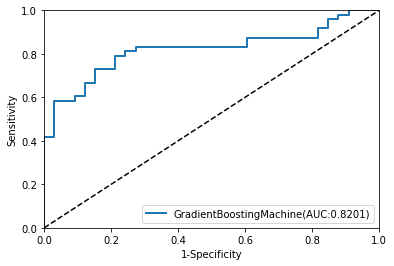

In [10]:
y_probs_gb_KAERS = xgb_KAERS.predict_proba(x_test_KAERS)
y_scores_gb_KAERS = y_probs_gb_KAERS[:,1]
fpr_gb_KAERS, tpr_gb_KAERS, thresholds_gb_KAERS = roc_curve(y_test_KAERS, y_scores_gb_KAERS)

plot_roc_curve(fpr_gb_KAERS, tpr_gb_KAERS, label='GradientBoostingMachine(AUC:0.8201)')
plt.legend(loc="lower right")
plt.show()

In [11]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier()

parameters_KAERS = {
    'n_estimators':[600],
    'max_depth':[12],'min_samples_split':[3],'min_samples_leaf':[3],
    'random_state':[111]}

rf_KAERS = GridSearchCV(rf_clf, param_grid=parameters_KAERS, scoring='roc_auc', cv=skf_infli, n_jobs = -1, verbose = -1)
rf_KAERS.fit(X_resampled_KAERS,y_resampled_KAERS)

print("최고 평균 성능 : {0:.4f}".format(rf_KAERS.best_score_))
print("최고의 파라미터: ", rf_KAERS.best_params_)

rf_roc_score_KAERS = roc_auc_score(y_test_KAERS, rf_KAERS.predict_proba(x_test_KAERS)[:,1], average='macro')
print('ROC AUC:{0:.4f}'.format(rf_roc_score_KAERS)) 

y_probs_rf_KAERS = rf_KAERS.predict_proba(x_test_KAERS)
y_scores_rf_KAERS = y_probs_rf_KAERS[:,1]
fpr_rf_KAERS, tpr_rf_KAERS, thresholds_rf_KAERS = roc_curve(y_test_KAERS, y_scores_rf_KAERS)

최고 평균 성능 : 0.8597
최고의 파라미터:  {'max_depth': 12, 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 600, 'random_state': 111}
ROC AUC:0.7948


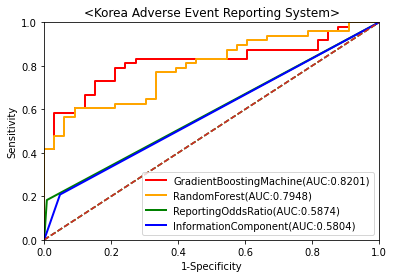

In [12]:
def plot_roc_curve_gbm_KAERS(fpr,tpr,label=None):
    plt.plot(fpr, tpr, linewidth=2, color='red', label=label)
    plt.plot([0,1],[0,1], linestyle= '--')
    plt.axis([0,1,0,1])
    plt.xlabel('1-Specificity')
    plt.ylabel('Sensitivity')
    plt.title('<Korea Adverse Event Reporting System>')

def plot_roc_curve_rf_KAERS(fpr,tpr,label=None):
    plt.plot(fpr, tpr, linewidth=2, color='orange', label=label)
    plt.plot([0,1],[0,1], linestyle= '--')
    plt.axis([0,1,0,1])
    plt.xlabel('1-Specificity')
    plt.ylabel('Sensitivity')
    
def plot_roc_curve_ror_KAERS(fpr,tpr,label=None):
    plt.plot(fpr, tpr, linewidth=2, color='green', label=label)
    plt.plot([0,1],[0,1], linestyle= '--')
    plt.axis([0,1,0,1])
    plt.xlabel('1-Specificity')
    plt.ylabel('Sensitivity')
    
def plot_roc_curve_ic_KAERS(fpr,tpr,label=None):
    plt.plot(fpr, tpr, linewidth=2, color='blue', label=label)
    plt.plot([0,1],[0,1], linestyle= '--')
    plt.axis([0,1,0,1])
    plt.xlabel('1-Specificity')
    plt.ylabel('Sensitivity')
    
tpr_ror_KAERS = [0,0.182741 ,1] 
fpr_ror_KAERS = [0,0.007874 ,1]

tpr_ic_KAERS = [0,0.208122,1]
fpr_ic_KAERS = [0,0.047240 ,1]
    
plot_roc_curve_gbm_KAERS(fpr_gb_KAERS, tpr_gb_KAERS,label='GradientBoostingMachine(AUC:0.8201)')
plot_roc_curve_rf_KAERS(fpr_rf_KAERS, tpr_rf_KAERS,label='RandomForest(AUC:0.7948)')
plot_roc_curve_ror_KAERS(fpr_ror_KAERS, tpr_ror_KAERS, label='ReportingOddsRatio(AUC:0.5874)')
plot_roc_curve_ic_KAERS(fpr_ic_KAERS, tpr_ic_KAERS, label='InformationComponent(AUC:0.5804)')
plt.legend(loc="lower right")
plt.savefig('KAERS', dpi=300)
plt.show()

In [124]:
GBM_KAERS_predictions = xgb_KAERS.predict_proba(x_test_KAERS)
threshold = 1
predicted_GBM_KAERS = (GBM_KAERS_predictions[:,1] >= threshold).astype('int')

confusion_matrix(y_test_KAERS, predicted_GBM_KAERS)

array([[33,  0],
       [48,  0]], dtype=int64)

In [23]:
data_unknown = pd.read_excel('머신러닝예측데이터셋.xlsx')
data_feature_UK = data_unknown.iloc[:,1:35]

data_feature_UK

preds = xgb_KAERS.predict_proba(data_feature_UK)
preds_df = pd.DataFrame(preds)

preds_df

preds_df.to_excel('D:/연구/Early detection/KAERS/실마리정보탐색.xlsx')
#threshold = 0.5
#predicted_rf = (preds[:,1] > threshold).astype('int')
#predicted_rf

In [113]:
RF_KAERS_predictions = rf_KAERS.predict_proba(x_test_KAERS)
threshold = 1
predicted_RF_KAERS = (RF_KAERS_predictions[:,1] >= threshold).astype('int')

confusion_matrix(y_test_KAERS, predicted_RF_KAERS)

array([[33,  0],
       [48,  0]], dtype=int64)

In [127]:
data_unknown = pd.read_excel('머신러닝예측데이터셋.xlsx')
data_feature_UK = data_unknown.iloc[:,1:35]

data_feature_UK

preds_rf = rf_KAERS.predict_proba(data_feature_UK)
preds_df_rf = pd.DataFrame(preds_rf)

preds_df_rf.to_excel('D:/연구/Early detection/KAERS/실마리정보탐색_랜덤포레스트.xlsx')